<h1> Copa America Winner Predictor </h1>

In [2781]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
import plotly.express as px
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
import optuna
from importlib import reload
import data_preprocessing
reload(data_preprocessing)
import hyperparameter_tunning
reload(hyperparameter_tunning)
import games
reload(games)
from data_preprocessing import full_merge_df, feature_engineering, preprcessing_classification, train_test_split, target_encoder
from hyperparameter_tunning import objective_log, objective_rf, objective_xgb
from games import group_arrangemnt, group_simulation, quaterfinals_games, knockout_predictions, semifinals_games


Data donwload and cleanning

In [2782]:
data_results= pd.read_csv('results.csv')
print(f'Shape of data set is {data_results.shape}')
print(f'Null values in results dataframe is {data_results.isna().values.any()}')

Shape of data set is (46442, 9)
Null values in results dataframe is False


In [2783]:
data_results['date']= pd.to_datetime(data_results['date'])

In [2784]:
data_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46442 entries, 0 to 46441
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        46442 non-null  datetime64[ns]
 1   home_team   46442 non-null  object        
 2   away_team   46442 non-null  object        
 3   home_score  46442 non-null  int64         
 4   away_score  46442 non-null  int64         
 5   tournament  46442 non-null  object        
 6   city        46442 non-null  object        
 7   country     46442 non-null  object        
 8   neutral     46442 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 2.9+ MB


<h1> Copa America Past Results </h1>

In [2785]:
data_results_copa_america= data_results[data_results['tournament']=='Copa América'].copy()

In [2786]:
data_results_copa_america['home_team'].value_counts()

home_team
Argentina        155
Brazil           137
Chile            109
Uruguay           71
Bolivia           68
Peru              62
Colombia          61
Paraguay          57
Ecuador           54
Mexico            24
Venezuela         20
United States     12
Honduras           3
Costa Rica         3
Haiti              1
Jamaica            1
Panama             1
Japan              1
Qatar              1
Name: count, dtype: int64

In [2787]:
data_results_copa_america.shape

(841, 9)

<h1>List of Teams playing Copa America</h1>

In [2788]:

teams_copa_america_2024= ['Argentina','Bolivia','Brazil', 'Chile', 'Canada', 'Colombia', 'Costa Rica', 'Ecuador', 'United States', 'Jamaica','Mexico','Panama','Paraguay', 'Peru','Uruguay', 'Venezuela']
data_results_copa_america_2024= data_results[(data_results['home_team'].isin(teams_copa_america_2024)) | (data_results['away_team'].isin(teams_copa_america_2024))]

<h1> Fifa Ranking Data Download  </h1>

In [2789]:
fifa_rankings= pd.read_csv('fifa_ranking-2024-04-04.csv')

<h1> Merge Data Frames </h1>

In [2790]:
data_results_copa_america_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7709 entries, 41 to 46440
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        7709 non-null   datetime64[ns]
 1   home_team   7709 non-null   object        
 2   away_team   7709 non-null   object        
 3   home_score  7709 non-null   int64         
 4   away_score  7709 non-null   int64         
 5   tournament  7709 non-null   object        
 6   city        7709 non-null   object        
 7   country     7709 non-null   object        
 8   neutral     7709 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 549.6+ KB


In [2791]:
df_full_results, fifa_rankings= full_merge_df(data_results_copa_america_2024, fifa_rankings,teams_copa_america_2024)

In [2792]:
df_full_results= feature_engineering(df_full_results)

<h1>Data Exploration</h1>

In [2793]:
df_full_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4202 entries, 0 to 4201
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       4202 non-null   datetime64[ns]
 1   away_team                  4202 non-null   object        
 2   home_team                  4202 non-null   object        
 3   home_score                 4202 non-null   int64         
 4   away_score                 4202 non-null   int64         
 5   tournament                 4202 non-null   object        
 6   city                       4202 non-null   object        
 7   country                    4202 non-null   object        
 8   neutral                    4202 non-null   bool          
 9   rank_home_team             4202 non-null   float64       
 10  total_points_home_team     4202 non-null   float64       
 11  previous_points_home_team  4202 non-null   float64       
 12  rank_c

In [2794]:
count_winners= df_full_results.groupby(by='winning_team', as_index=False).size()
count_winners

,winning_team,size
0,away_team,1088
1,home_team,2091
2,tied,1023


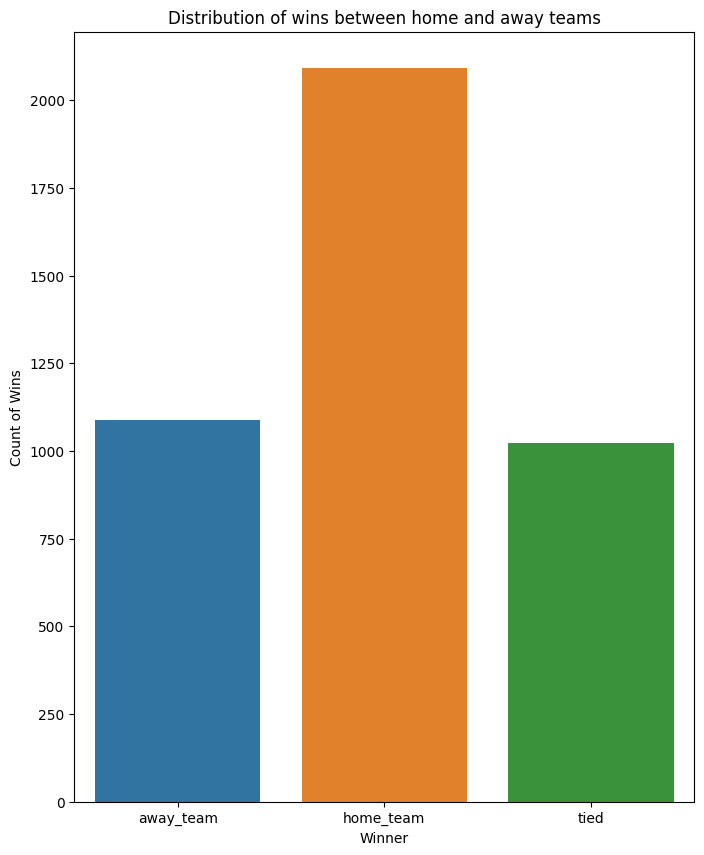

In [2795]:
plt.figure(figsize=(8,10))
sns.barplot(data= count_winners, x='winning_team', y= 'size', hue='winning_team')
plt.title("Distribution of wins between home and away teams")
plt.ylabel("Count of Wins")
plt.xlabel("Winner")
plt.show()


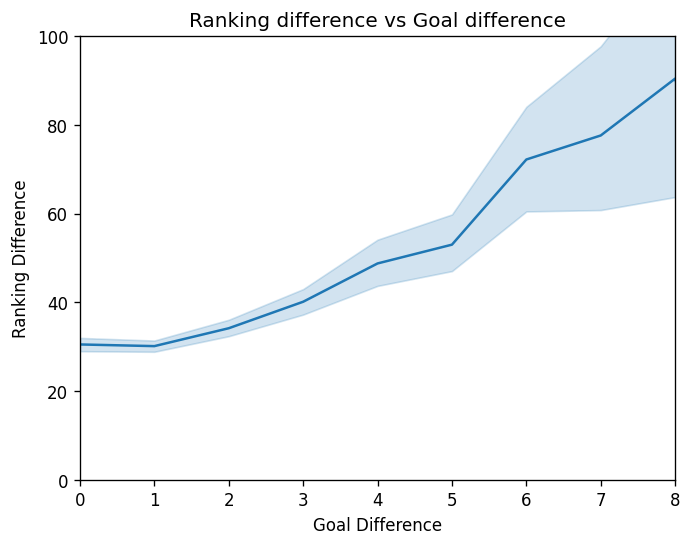

In [2796]:
plt.figure(dpi=120)
sns.lineplot(data= df_full_results, x=df_full_results['goal_difference'], y=df_full_results['ranking_diff'])
plt.xlim((0,8))
plt.ylim((0,100))
plt.title('Ranking difference vs Goal difference')
plt.xlabel('Goal Difference')
plt.ylabel('Ranking Difference')
plt.show()


In [2797]:
final_copa_america_df= df_full_results.sort_values(by='date', ascending= True)


In [2798]:
def winner_country(away_team, away_score, home_team, home_score):
    if home_score > away_score:
        return home_team
    
    elif home_score < away_score:
        return away_team
    
    else:
        return 'tied'

In [2799]:
winners= final_copa_america_df.apply(lambda x: winner_country(x['away_team'], x['away_score'], x['home_team'], x['home_score']), axis=1)
winners= winners[winners.isin(teams_copa_america_2024)]
winners_counts= winners.value_counts()

In [2800]:
h_bar= px.bar(x= winners_counts.index,
              y= winners_counts.values,
              color= winners_counts.index,
              color_continuous_scale='Viridis',
              title= 'Count of Wins per Copa America Team Since Rankings')
h_bar.update_layout(xaxis_title= "Country",
                    yaxis_title='Number of Wins',
                    coloraxis_showscale= False)
h_bar.show()

In [2801]:
final_copa_america_df['total_points_diff']= (final_copa_america_df['total_points_home_team'] - final_copa_america_df['total_points_away_team']).abs()

In [2802]:
final_copa_america_df.head(10)

,date,away_team,home_team,home_score,away_score,tournament,city,country,neutral,rank_home_team,...,rank_away_team,total_points_away_team,previous_points_away_team,rank_change_away_team,confederation_away_team,winning_team,goal_difference,total_point_difference,ranking_diff,total_points_diff
0,1993-01-20,Mexico,Italy,2,0,Friendly,Florence,Italy,False,2.0,...,25.0,43.0,0.0,25,CONCACAF,home_team,2,0.0,23.0,14.0
1,1993-01-23,Peru,Venezuela,0,0,Friendly,Puerto Ordaz,Venezuela,False,125.0,...,78.0,16.0,0.0,78,CONMEBOL,tied,0,0.0,47.0,11.0
2,1993-01-25,Russia,Bolivia,1,2,Nehru Cup,Madras,India,True,87.0,...,8.0,52.0,0.0,8,UEFA,away_team,1,0.0,79.0,38.0
3,1993-01-27,Belarus,Ecuador,1,1,Friendly,Guayaquil,Ecuador,False,65.0,...,146.0,1.0,0.0,146,UEFA,tied,0,0.0,81.0,22.0
4,1993-01-27,Honduras,Peru,1,1,Friendly,Lima,Peru,False,78.0,...,40.0,32.0,0.0,40,CONCACAF,tied,0,0.0,38.0,16.0
5,1993-01-27,Mexico,Spain,1,1,Friendly,Las Palmas,Spain,False,15.0,...,25.0,43.0,0.0,25,CONCACAF,tied,0,0.0,10.0,6.0
6,1993-01-29,Honduras,Bolivia,3,1,Friendly,Cochabamba,Bolivia,False,87.0,...,40.0,32.0,0.0,40,CONCACAF,home_team,2,0.0,47.0,18.0
7,1993-01-30,Belarus,Peru,1,1,Friendly,Lima,Peru,False,78.0,...,146.0,1.0,0.0,146,UEFA,tied,0,0.0,68.0,15.0
8,1993-01-30,Denmark,United States,2,2,Friendly,Tempe,United States,False,24.0,...,9.0,52.0,0.0,9,UEFA,tied,0,0.0,15.0,9.0
9,1993-01-31,Romania,Ecuador,3,0,Friendly,Guayaquil,Ecuador,False,65.0,...,11.0,51.0,0.0,11,UEFA,home_team,3,0.0,54.0,28.0


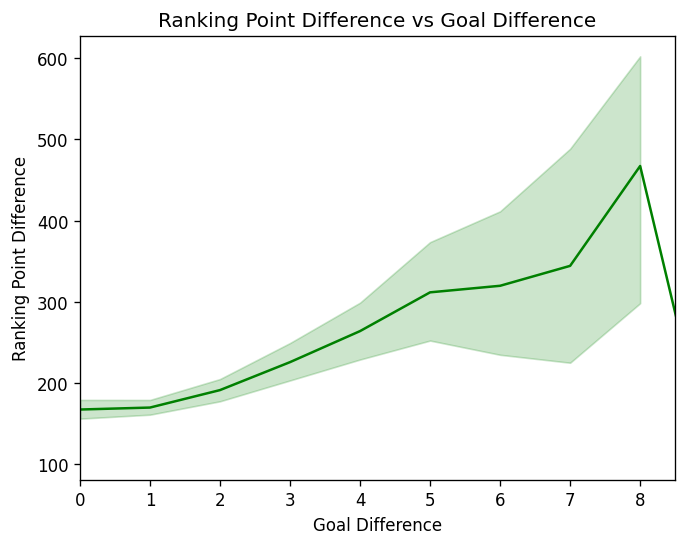

In [2803]:
plt.figure(dpi=120)
sns.lineplot(data= final_copa_america_df, x= final_copa_america_df.goal_difference, y= final_copa_america_df.total_points_diff, c= 'green')
plt.xlim((0,8.5))
plt.title('Ranking Point Difference vs Goal Difference')
plt.ylabel('Ranking Point Difference')
plt.xlabel('Goal Difference')
plt.show()

In [2804]:
data_results_copa_america['winner']= data_results_copa_america.apply(lambda x : winner_country(x['away_team'], x['away_score'], x['home_team'], x['home_score']), axis=1)
winners_copa_america= data_results_copa_america[data_results_copa_america['winner'] != 'tied']['winner'].value_counts()

In [2805]:
h_bar_copa_america= px.bar(x= winners_copa_america.index, 
                           y= winners_copa_america.values,
                           color= winners_copa_america.index,
                           color_continuous_scale= 'Viridis',
                           title= 'Count of Wins per Team in Copa America Competition')
h_bar_copa_america.update_layout(xaxis_title='Countries',
                    yaxis_title='Number of Wins',
                    coloraxis_showscale= False)
h_bar_copa_america.show()

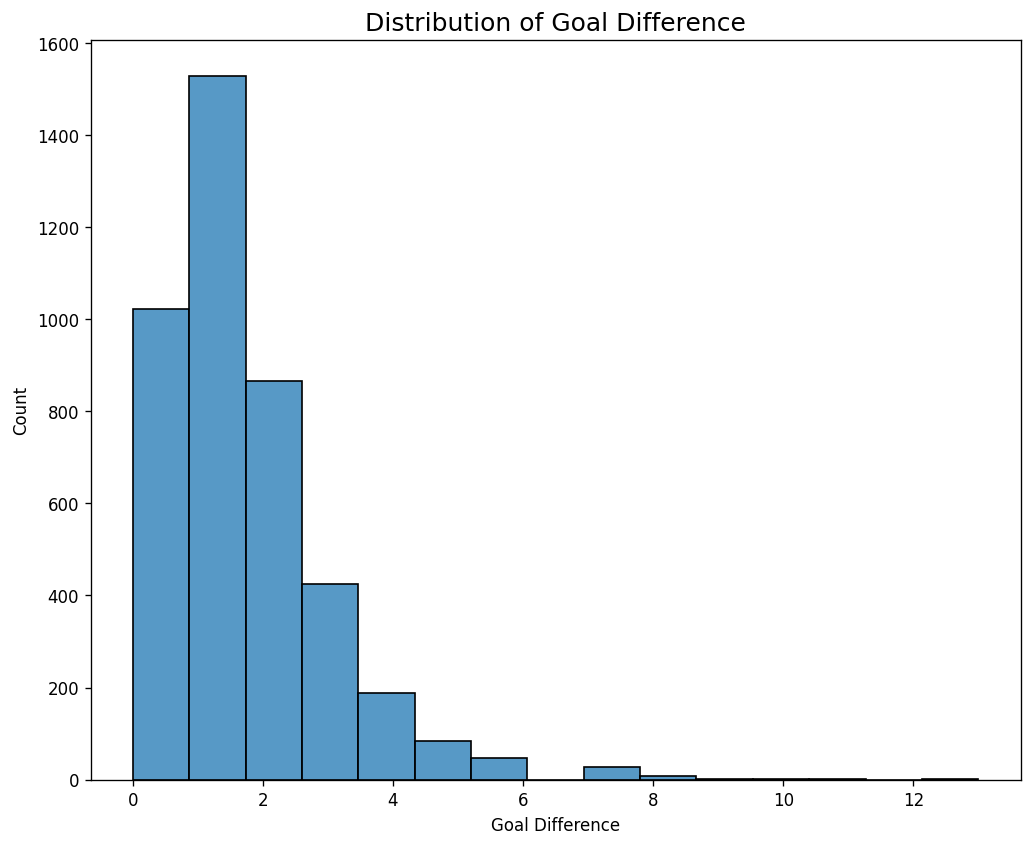

In [2806]:
plt.figure(figsize=(10,8), dpi= 120)
sns.histplot(data=final_copa_america_df, x= final_copa_america_df['goal_difference'], bins= 15)
plt.title('Distribution of Goal Difference', fontsize=15)
plt.xlabel('Goal Difference')
plt.ylabel('Count')
plt.show()

<h1> Data Preprocessing </h1>

<h2> Country Encoder </h2>

In [2807]:
countries= pd.concat([final_copa_america_df['away_team'],final_copa_america_df['home_team']]).unique().reshape(-1,1)
country_encoder= OneHotEncoder(sparse_output= False)
country_encoder.fit(countries)

OneHotEncoder(sparse_output=False)

<h1> Multi Class Classification </h1>

In [2808]:
features_multi_class,target_multi_class= preprcessing_classification(final_copa_america_df,country_encoder)


In [2809]:
features_multi_class.shape

(4202, 267)

In [2810]:
target_multi_class.shape

(4202,)

In [2811]:
X_train, y_train, X_val, y_val, X_test, y_test= train_test_split(features_multi_class,target_multi_class, train_per=0.70, test_set= True)

631


<h2> Standarize Data </h2>

In [2812]:
scaler= StandardScaler()

X_train = scaler.fit_transform(X_train[['rank_home_team', 'rank_away_team', 'total_points_away_team', 'total_points_home_team', 'neutral']])
X_val= scaler.fit_transform(X_val[['rank_home_team', 'rank_away_team', 'total_points_away_team', 'total_points_home_team', 'neutral']])
X_test= scaler.fit_transform(X_test[['rank_home_team', 'rank_away_team', 'total_points_away_team', 'total_points_home_team', 'neutral']])

<h2> Logistic Regression </h2>

In [2813]:
study= optuna.create_study(direction= 'maximize')
study.optimize(lambda trial: objective_log(trial,X_train, y_train, X_val, y_val ), n_trials= 100)

print('Best Accuracy: ', study.best_value)
best_params= study.best_params

Best Accuracy:  0.5483359746434231


In [2814]:
model= LogisticRegression(solver='lbfgs', max_iter= best_params['max_iter'], C= best_params['C'], class_weight='balanced')
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
accuracy_log= accuracy_score(y_test, y_pred)
print(accuracy_log)

0.5873015873015873


<Axes: >

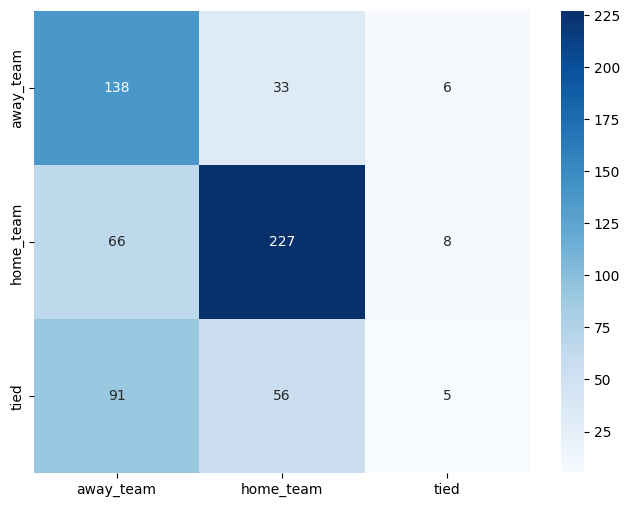

In [2815]:
cm_logistic= confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logistic, annot= True, fmt= 'd', cmap='Blues',xticklabels= model.classes_, yticklabels= model.classes_)

<h1> Random Forest </h1>

<h3> Optuna Hyperparameter Tunning </h3>

In [2816]:
study= optuna.create_study(direction= 'maximize')
study.optimize(lambda trial: objective_rf(trial,X_train,y_train, X_val,y_val), n_trials= 100)

print('Best MSE: ', study.best_value)
best_params= study.best_params

Best MSE:  0.5657686212361331


In [2817]:
best_model= RandomForestClassifier(n_estimators= best_params['n_estimators'], 
                                  max_depth=best_params['max_depth'], 
                                  min_samples_split= best_params['min_samples_split'], 
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  random_state=42)

best_model.fit(X_train, y_train)
y_pred_test= best_model.predict(X_test)
accuracy_rf= accuracy_score(y_test, y_pred_test)
print(accuracy_rf)

0.5857142857142857


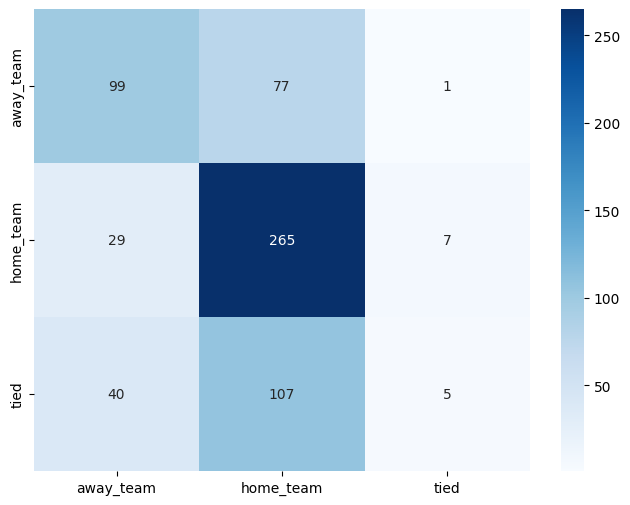

In [2818]:

cm_random_forest= confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm_random_forest, annot= True, fmt= 'd', cmap='Blues',xticklabels= model.classes_, yticklabels= model.classes_)
plt.show()

<h2> XGBoost Classifier </h2>

In [2819]:
y_train_enc, y_val_enc, y_test_enc= target_encoder(y_train, y_val, y_test)

<h3>Optuna Tunning </h3>

In [2820]:
study= optuna.create_study(direction= 'maximize')
study.optimize(lambda trial: objective_xgb(trial, X_train, y_train_enc, X_val, y_val_enc), n_trials= 100)

print('Best Accuracy Score: ', study.best_value)
best_params= study.best_params
print(best_params)

Best Accuracy Score:  0.5625990491283677
{'n_estimators': 105, 'learning_rate': 0.023357214690901212, 'max_depth': 3}


In [2821]:
model= XGBClassifier(objective='multi:softmax', num_class= 3, n_estimators= best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth= best_params['max_depth'], random_state=42)
model.fit(X_train, y_train_enc)
y_pred= model.predict(X_test)
accuracy_xgb= accuracy_score(y_test_enc, y_pred)
print(accuracy_xgb)


0.553968253968254


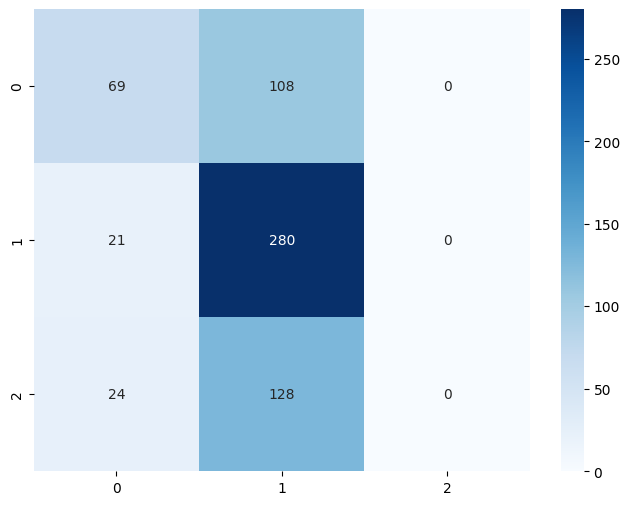

In [2822]:
cm_xgboost= confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgboost,annot= True, fmt= 'd', cmap='Blues',xticklabels= model.classes_, yticklabels= model.classes_)
plt.show()

<h1> Comparison of Accuracies based on validation </h1>

In [2823]:
dict_accuracy_scores={'XgBoost': accuracy_xgb,
                      'Random Forest':accuracy_rf,
                      'Logistic Regression': accuracy_log}

bar_accuraies= px.bar(x= dict_accuracy_scores.keys(),
                      y= dict_accuracy_scores.values(),
                      color= dict_accuracy_scores.keys(),
                      color_continuous_scale='Viridis',
                      title= 'Accuracies Per Model')
bar_accuraies.update_layout(xaxis_title='Model',
                            yaxis_title='Accuracy')
bar_accuraies.show()

<h1> Linear Regression </h1>

In [2824]:
df_copa_regression= final_copa_america_df[['date','away_team','home_team','ranking_diff','total_points_diff','goal_difference']].copy()
df_copa_regression= df_copa_regression[df_copa_regression['goal_difference']< 4]


In [2825]:
# df_copa_regression['encoded_away_team']= label_encoder_countries.transform(df_copa_regression['away_team'])
# df_copa_regression['encoded_home_team']= label_encoder_countries.transform(df_copa_regression['home_team'])
features_regression= df_copa_regression.drop(['away_team','home_team','date','goal_difference'], axis=1)
target_regression= df_copa_regression['goal_difference']

<h3> Data Split </h3>

In [2826]:
train_size= int(len(features_regression)*0.70)
val_size= int(len(features_regression)*0.15)+1
test_size= int(len(features_regression)*0.15)+1

In [2827]:
X_train= features_regression[:train_size]
y_train= target_regression[:train_size]
X_val= features_regression[train_size:train_size + val_size]
y_val= target_regression[train_size:train_size + val_size]
X_test= features_regression[train_size + val_size:]
y_test= target_regression[train_size + val_size:]

print(len(X_train))
print(len(X_val))
print(len(X_test))

2689
577
576


In [2828]:
scaler= StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val= scaler.fit_transform(X_val)
X_test= scaler.fit_transform(X_test)

<h3> Linear Regression </h3>

In [2829]:
model= LinearRegression()
model.fit(X_train, y_train)
prediction= model.predict(X_val)
score= model.score(X_val, y_val)
mse= mean_squared_error(y_val, prediction)
print(score)
print(mse)


0.015485107310306723
0.8992519149949839


<h3> Random forest Regression </h3>

In [2830]:
model= RandomForestRegressor(n_estimators= 200, random_state= 42)
model.fit(X_train, y_train)
prediction= model.predict(X_val)
mse= mean_squared_error(y_val, prediction)
r2= r2_score(y_val, prediction)

In [2831]:
print(mse)
print(r2)

1.1684035832990782
-0.2791862983537394


<h3> XGBoost </h3>

In [2832]:
model= XGBRegressor(objective= 'reg:squarederror', n_estimators=2, learning_rate= 0.1, max_depth= 5, random_state=42)
model.fit(X_train, y_train)
y_pred= model.predict(X_val)

mse= mean_squared_error(y_val, y_pred)
r2= r2_score(y_val, y_pred)
print(mse)
print(r2)

0.9094385451068271
0.0043326616287231445


<h1> Copa America Simulation </h1>

<h3> Copa America Teams Rankings </h3>

In [2833]:
copa_america_rankings= fifa_rankings[(fifa_rankings['rank_date']=='2024-04-04') & fifa_rankings['country_full'].isin(teams_copa_america_2024)]


In [2834]:
groupA=['Argentina', 'Peru', 'Chile', 'Canada']
groupB= ['Mexico', 'Ecuador', 'Venezuela', 'Jamaica']
groupC=['United States', 'Uruguay', 'Panama', 'Bolivia']
groupD=['Brazil', 'Colombia', 'Paraguay', 'Costa Rica']

<h2> Groups Simulation </h2>

<h3> Group A simulation </h3>

In [2835]:
groupA_games= group_arrangemnt(groupA)
groupA_table= group_simulation(groupA,groupA_games,country_encoder,final_copa_america_df,copa_america_rankings)
groupA_table.head()

,Teams,Points
0,Argentina,9
1,Peru,6
2,Chile,3
3,Canada,0


<h3> Group B Simulation </h3>

In [2836]:
groupB_games= group_arrangemnt(groupB)
groupB_table= group_simulation(groupB,groupB_games,country_encoder,final_copa_america_df,copa_america_rankings)
groupB_table.head()

,Teams,Points
0,Mexico,7
1,Ecuador,2
2,Venezuela,1
3,Jamaica,6


<h3> Group C Simulation </h3>

In [2837]:
groupC_games= group_arrangemnt(groupC)
groupC_table= group_simulation(groupC,groupC_games,country_encoder,final_copa_america_df,copa_america_rankings)
groupC_table.head()

,Teams,Points
0,United States,9
1,Uruguay,6
2,Panama,3
3,Bolivia,0


<h3>Group D group_simulation</h4>

In [2838]:
groupD_games= group_arrangemnt(groupD)
groupD_table= group_simulation(groupD,groupD_games,country_encoder,final_copa_america_df, copa_america_rankings)
groupD_table.head()

,Teams,Points
0,Brazil,9
1,Colombia,6
2,Paraguay,3
3,Costa Rica,0


<h3> Quaterfinals </h3>

In [2839]:

quaterfinals= quaterfinals_games(groupA_table, groupB_table, groupC_table, groupD_table)



semifinals_teams= knockout_predictions(quaterfinals,country_encoder, final_copa_america_df, copa_america_rankings)


    Jamaica  Argentina      tied
0  0.154748     0.6935  0.151752


       Peru    Mexico      tied
0  0.280604  0.398344  0.321052


   Colombia  United States     tied
0    0.2669        0.32775  0.40535


   Uruguay    Brazil      tied
0  0.23788  0.433717  0.328404


<h3> Semmifinals </h3>

In [2840]:
finals= semifinals_games(semifinals_teams)

In [2841]:
final= knockout_predictions(finals,country_encoder,final_copa_america_df, copa_america_rankings)

     Mexico  Argentina      tied
0  0.258792   0.557861  0.183346


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
final_game=[final]
winner=knockout_predictions(final_game,country_encoder, final_copa_america_df, copa_america_rankings)
print(f'The Winner of Copa America 2024 is: {winner[0]}')

Index(['away_team_Albania', 'away_team_Algeria', 'away_team_Andorra',
       'away_team_Angola', 'away_team_Anguilla',
       'away_team_Antigua and Barbuda', 'away_team_Argentina',
       'away_team_Armenia', 'away_team_Aruba', 'away_team_Australia',
       ...
       'home_team_Wales', 'home_team_Zambia', 'home_team_Zimbabwe',
       'rank_home_team', 'rank_away_team', 'total_points_away_team',
       'total_points_home_team', 'neutral', 'ranking_diff',
       'total_point_difference'],
      dtype='object', length=267)


ValueError: feature_names mismatch: ['away_team_United States', 'away_team_Argentina', 'home_team_United States', 'home_team_Argentina', 'rank_home_team', 'rank_away_team', 'neutral', 'ranking_diff', 'total_point_difference'] ['away_team_Argentina', 'away_team_United States', 'home_team_Argentina', 'home_team_United States', 'rank_home_team', 'rank_away_team', 'neutral', 'ranking_diff', 'total_point_difference']